In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [92]:
class Environment:
    def __init__(self):
        self.width_range = (0, 75)
        self.height_range = (0, 75)
        self.obstacles = self.generate_obstacles()

    @staticmethod
    def generate_obstacles():
        obstacles = [
            [30, 30, 10, 5],
            [10, 50, 20, 20],
            [60, 10, 15, 10],
            [32, 14, 10, 2]
        ]
        return obstacles

env = Environment()
print("Obstacles:", env.obstacles)

Obstacles: [[30, 30, 10, 5], [10, 50, 20, 20], [60, 10, 15, 10], [32, 14, 10, 2]]


In [100]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.cost = 0.0

class RRTStar:
    def __init__(self, environment, start, goal, max_iterations=2000, step_size=2.0, goal_radius=1.0, search_radius=5.0):
        self.env = environment
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.max_iterations = max_iterations
        self.step_size = step_size
        self.goal_radius = goal_radius
        self.search_radius = search_radius
        self.nodes = [self.start]
        self.path = []

    #FINDING DISTANCE BETWEEN TWO NODES
    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x)**2 + (node1.y - node2.y)**2)
    
    #CHECKING COLLISION WITH OBSTACLES
    def is_collision_free(self, new_node, nearest_node):
        line = [[nearest_node.x, nearest_node.y], [new_node.x, new_node.y]]
        for obstacle in self.env.obstacles:
            if self.is_intersect(line, obstacle):
                return False

        for obstacle in self.env.obstacles:
            x, y, w, h = obstacle
            if (
                x <= new_node.x <= x + w and
                y <= new_node.y <= y + h
            ):
                return False

        return True

    def is_intersect(self, line, obstacle):
        x1, y1 = line[0]
        x2, y2 = line[1]
        x3, y3, w, h = obstacle
        x4, y4 = x3 + w, y3 + h

        if (x2 <= x3 or x1 >= x4 or y2 <= y3 or y1 >= y4):
            return False

        if (x1 >= x3 and x1 <= x4 and y1 >= y3 and y1 <= y4):
            return True

        if (x2 >= x3 and x2 <= x4 and y2 >= y3 and y2 <= y4):
            return True

        return ((x1 - x3) * (y4 - y3) - (y1 - y3) * (x4 - x3)) * ((x2 - x3) * (y4 - y3) - (y2 - y3) * (x4 - x3)) < 0

    # FINDING NEAREST NODE TO A RANDOM NODE
    def find_nearest_node(self, random_node):
        min_dist = float('inf')
        nearest_node = None

        for node in self.nodes:
            d = self.distance(node, random_node)
            if d < min_dist:
                min_dist = d
                nearest_node = node

        return nearest_node
    
    # FIND NODES WITHIN THE SEARCH RADIUS
    def find_near_nodes(self, random_node):
        near_nodes = [node for node in self.nodes if self.distance(node, random_node) < self.search_radius]
        return near_nodes

    def reform(self, new_node, near_nodes):
        for node in near_nodes:
            if node == new_node.parent:
                continue

            tentative_cost = node.cost + self.distance(node, new_node)

            if tentative_cost < new_node.cost and self.is_collision_free(new_node, node):
                new_node.parent = node
                new_node.cost = tentative_cost
                self.add_cost(new_node)
    
    # UPDATE COST
    def add_cost(self, parent_node):
        for node in self.nodes:
            if node.parent == parent_node:
                node.cost = parent_node.cost + self.distance(node, parent_node)
                self.add_cost(node)

    def generate_random_node(self):
        if random.random() < 0.05:  # 5% chance to select the goal as the random node
            return Node(self.goal.x, self.goal.y)
        else:
            x = random.uniform(self.env.width_range[0], self.env.width_range[1])
            y = random.uniform(self.env.height_range[0], self.env.height_range[1])
            return Node(x, y)

    def plan(self):
        # create random node and find its nearest node
        for i in range(self.max_iterations):
            random_node = self.generate_random_node()
            nearest_node = self.find_nearest_node(random_node)
            
            #check if distance between nearest node and the generated node is greater than step size
            if self.distance(nearest_node, random_node) > self.step_size:
                theta = math.atan2(random_node.y - nearest_node.y, random_node.x - nearest_node.x)
                new_node = Node(nearest_node.x + self.step_size * math.cos(theta),
                                nearest_node.y + self.step_size * math.sin(theta))
            else:
                new_node = random_node

            if not self.is_collision_free(new_node, nearest_node):
                continue
            
            #find nodes within the search radius
            near_nodes = self.find_near_nodes(new_node)
            new_node.parent = nearest_node
            new_node.cost = nearest_node.cost + self.distance(new_node, nearest_node)

            self.reform(new_node, near_nodes)
            self.nodes.append(new_node)
            
            # check if we reached near the goal
            if self.distance(new_node, self.goal) < self.goal_radius:
                self.goal.parent = new_node
                self.goal.cost = new_node.cost + self.distance(self.goal, new_node)
                self.add_cost(self.goal)
                break
    
    #finding the optimal path
    def extract_path(self):
        current_node = self.goal
        while current_node is not None:
            self.path.append((current_node.x, current_node.y))
            current_node = current_node.parent
        self.path.reverse()

    def plot(self):
        plt.figure(figsize=(10, 10))

        #plotting obstacles
        for obstacle in self.env.obstacles:
            obstacle_rect = plt.Rectangle((obstacle[0], obstacle[1]), obstacle[2], obstacle[3], fc='r')
            plt.gca().add_patch(obstacle_rect)

        #plotting all nodes generated
        for node in self.nodes:
            if node.parent:
                plt.plot([node.x, node.parent.x], [node.y, node.parent.y], '-o', color='#000000',)
        
        #plotting optimal path in green
        for i in range(len(self.path) - 1):
            plt.plot([self.path[i][0], self.path[i + 1][0]], [self.path[i][1], self.path[i + 1][1]], '-o', color='#00FF00', markersize=5)

        #plotting start and goal points
        plt.plot(self.start.x, self.start.y, 'mo', markersize=15, label='Start')
        plt.plot(self.goal.x, self.goal.y, 'co', markersize=15, label='Goal')

        plt.legend()
        plt.grid(True)
        plt.savefig('path.jpg')
        plt.show()

Optimal Path: [(1, 1), (3.9951735495403056, 3.6206051713508423), (7.056434285446481, 5.747366491658243), (8.288328102377513, 7.322941822706268), (11.443531560509918, 8.160651420321507), (12.818672084030716, 9.612887124527592), (15.68753901217432, 13.530168611446156), (19.37440082541085, 16.57178870293997), (22.368815587106493, 18.449492651762824), (24.679135563977574, 21.50620764983204), (25.872685511705875, 24.930876839901522), (27.041920748172803, 28.192137824930846), (28.323599722973835, 29.727487624016703), (29.024816148054324, 32.910614368544955), (30.40549581898916, 36.204100524233965), (32.73760963069886, 39.299499357282585), (36.52477279756914, 41.80833192601638), (39.052227282034394, 44.83004678165335), (42.328270821488346, 46.871662613840776), (46.732643481236295, 46.90042995942401), (50.0137981287465, 48.96383881627735), (51.607817481720886, 50.171771886585105), (54.37834696645476, 52.49392385558051), (55.70996238917103, 53.98617060661874), (58.65153790294693, 56.66502112690

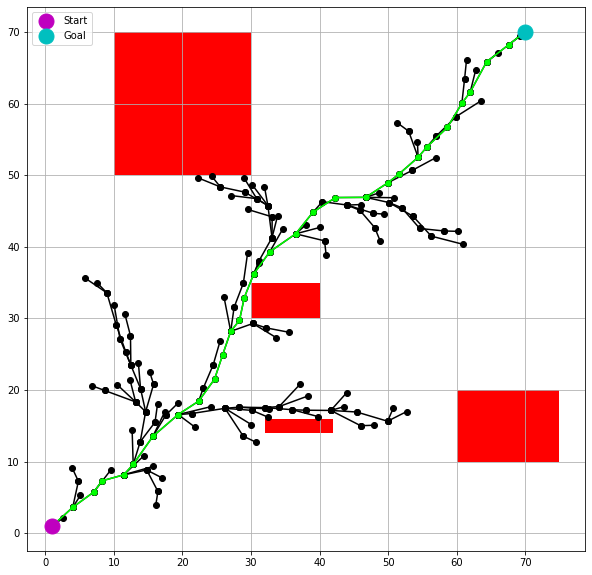

In [101]:
start_point = (1, 1)
goal_point = (70, 70)

env = Environment()
rrt_star = RRTStar(env, start_point, goal_point)

rrt_star.plan()

rrt_star.extract_path()
print("Optimal Path:", rrt_star.path)

rrt_star.plot()
